In [24]:
import random
import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
from helper_functions import load_n_samples, load_balanced_n_samples, convert_labels
from evaluation import get_results_dict

In [3]:
data_dir = '../data'
eval_set = 'dev_sample'
n_eval = -1

budgets_all = [16, 32, 64, 128, 256, 514, 1024]
models = ['Multinomial NB', 'Complement NB', 'Multinomial NB \n + log weighting', 'Complement NB \n+ log weighting']

In [4]:
def init_results_dict():

        nested_dict = {
                'balanced': {
                        'balanced': {},
                        'unbalanced': {},
                },
                'unbalanced': {
                        'balanced': {},
                        'unbalanced': {},
                },
        }

        results_dict = {}
        results_dict['binary_movie_sentiment'] = nested_dict
        results_dict['binary_abuse'] = nested_dict

        return results_dict

In [25]:
seeds = range(10)
budgets = budgets_all[1:]

task = "binary_abuse"

results_dict_binary_abuse = init_results_dict()
list_results_binary_abuse_to_save = []

for balanced_train, train in [(False, 'unbalanced'), (True, 'balanced')]:
    for balanced_eval, eval in [(False, 'unbalanced'), (True, 'balanced')]:
        
        f1_macros = np.zeros((len(seeds), len(budgets)))
        over_predictions = np.zeros((len(seeds), len(budgets)))

        for (j, n_train) in enumerate(budgets):
            #print(f"{train} train, {eval} test, {n_train} ")
            for (i, seed) in enumerate(seeds):
                # prepare dataset
                raw_dataset = {}
                if balanced_train is False:
                    if task == 'binary_movie_sentiment' :
                        random.seed(seed)
                        filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
                        n = sum(1 for line in open(filename)) - 1
                        skip = sorted(random.sample(range(1, n + 1), n - n_train))
                        df = pd.read_csv(filename, skiprows=skip)
                        raw_dataset['train'], n_classes_train = convert_labels(df)
                    else:
                        raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                                seed=seed))
                else:
                    raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                                    n_train, seed=seed))
                balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
                final_eval_set = balanced_eval_suffix + eval_set
                raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

                vectorizer = TfidfVectorizer()
                X = vectorizer.fit_transform(raw_dataset['train']['text'])
                train_labels = raw_dataset['train']['label']
                ys = vectorizer.transform(raw_dataset['eval']['text'])
                eval_labels = raw_dataset['eval']['label']

                # Define the logistic regression model
                model = LogisticRegression(solver='liblinear', penalty='l2')  # Use 'liblinear' for small datasets or L1 penalty

                # Define the parameter grid for the penalty strength
                param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # C is the inverse of the regularization strength

                # Define the scoring function as F1 score
                f1_scorer = make_scorer(f1_score, average="macro", zero_division=0)

                if balanced_train is False and n_train == 16:
                    folds = 2
                else:
                    folds = 4

                start = time.time()
                # Use GridSearchCV to find the best C value
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring=f1_scorer,
                    cv=KFold(n_splits=folds),  # 3-fold cross-validation
                    verbose=0,
                )

                # Fit the grid search to the training data
                grid_search.fit(X, train_labels)

                # Get the best model
                best_model = grid_search.best_estimator_
                #print(f"Best C value: {grid_search.best_params_['C']}")
                #print(f"Best F1 Score: {grid_search.best_score_}")

                end = time.time()
                # Evaluate on the test set
                predicted_labels = best_model.predict(ys)
                test_f1 = f1_score(eval_labels, predicted_labels, average="macro", zero_division=0)
                #print(f"Test F1 Score: {test_f1}")

                runtime = end-start
                datetime_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                d = get_results_dict(task, "logistic_regression", "logistic_regression", runtime, eval_labels,
                                    predicted_labels, eval_set, n_train, n_eval, balanced_train, balanced_eval,
                                    seed, datetime_str)
                d["f1-macro"] = test_f1
                list_results_binary_abuse_to_save.append(d)

                if n_train == budgets[-1]:
                    total = len(predicted_labels)
                    df = pd.DataFrame(data={'predictions': predicted_labels, 'ground_truth': raw_dataset['eval']['label']})
                    over_predictions[i, 0] = len(df.loc[(df.ground_truth==1) & (df.predictions==0)])*100/total
                    over_predictions[i, 1] = len(df.loc[(df.ground_truth==0) & (df.predictions==1)])*100/total

                f1_macros[i, j] = test_f1

        results_dict_binary_abuse[task][train][eval]['f1_macro'] = f1_macros
        results_dict_binary_abuse[task][train][eval]['over_predictions'] = over_predictions

print(f"{task} done")


binary_abuse done


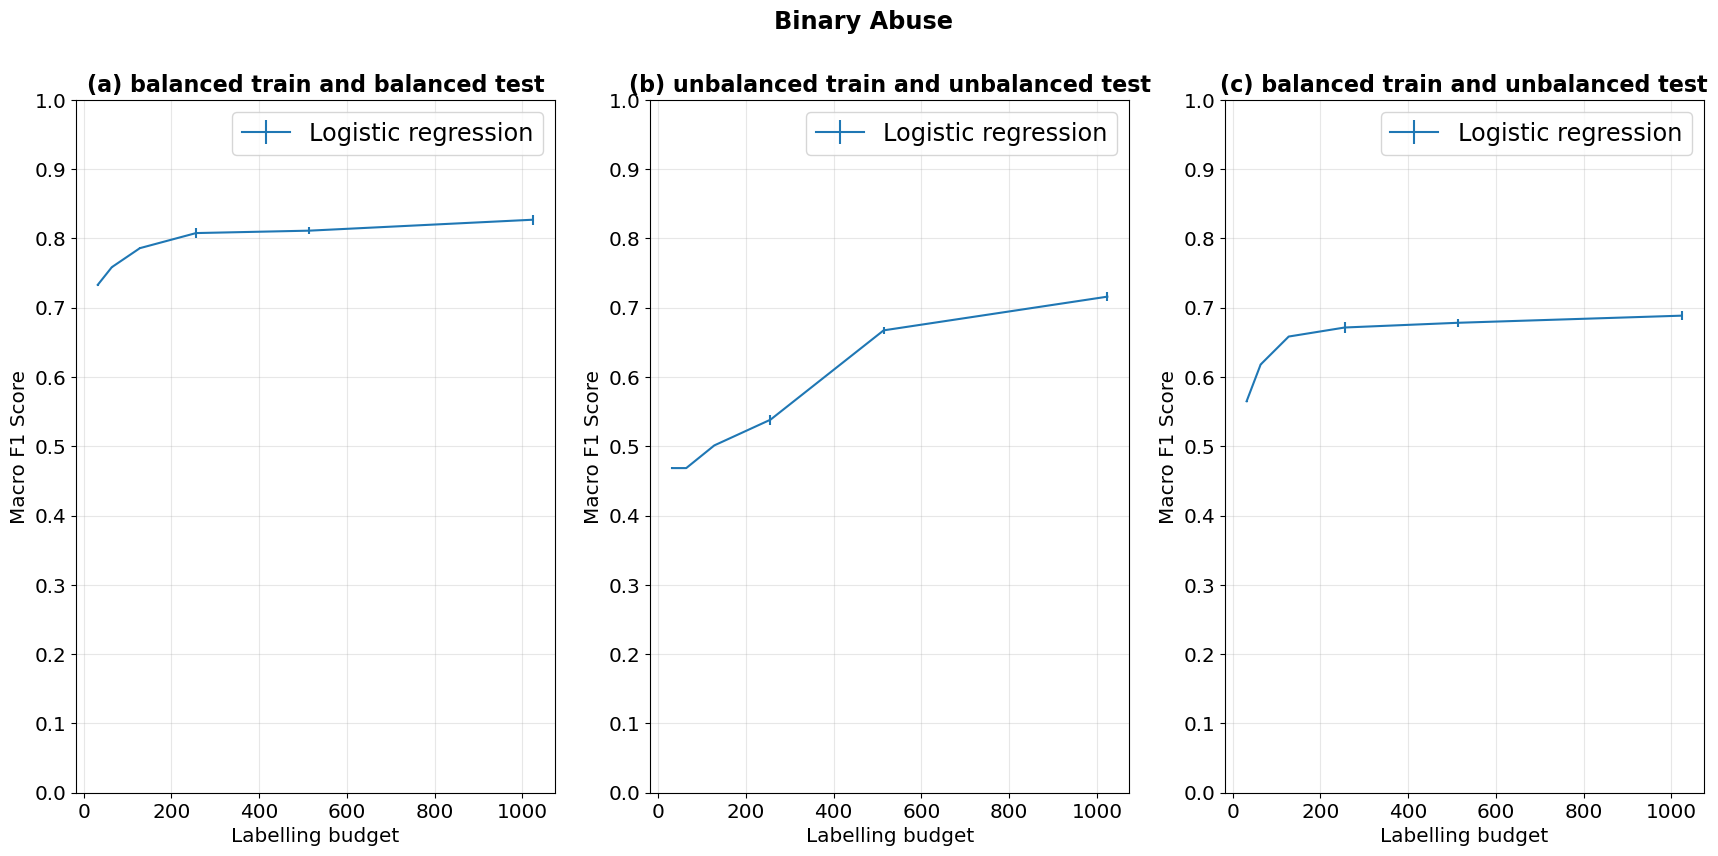

In [13]:
task = "binary_abuse"
fig, axes = plt.subplots(1, 3, figsize=(21, 9))

fig.suptitle(task.replace("_", " ").title(), fontsize='xx-large', fontweight='semibold')

axes[0].errorbar(x=budgets, y=results_dict_binary_abuse[task]["balanced"]["balanced"]["f1_macro"].mean(axis=0), 
                yerr=results_dict_binary_abuse[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), label="Logistic regression")
axes[1].errorbar(x=budgets, y=results_dict_binary_abuse[task]["unbalanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                yerr=results_dict_binary_abuse[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), label="Logistic regression")
axes[2].errorbar(x=budgets, y=results_dict_binary_abuse[task]["balanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_binary_abuse[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), label="Logistic regression")

for i in range(3):
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim((0., 1))
    axes[i].set_ylabel("Macro F1 Score", size='x-large')
    axes[i].set_xlabel("Labelling budget", size='x-large')
    axes[i].set_yticks(np.linspace(0, 1, 11))
    axes[i].tick_params(axis='both', which='major', labelsize='x-large')
    axes[i].legend(loc=1, fontsize='xx-large')


axes[0].set_title("(a) balanced train and balanced test", fontweight = 'semibold', fontsize = 16)
axes[1].set_title("(b) unbalanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)
axes[2].set_title("(c) balanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)

plt.savefig("logistic_binary_abuse.png", format="png", bbox_inches="tight")

In [26]:
seeds = range(10)
budgets = budgets_all[1:]

task = "binary_movie_sentiment"

results_dict_binary_movie_sentiment = init_results_dict()
list_results_movie_sentiment_to_save = []

for balanced_train, train in [(False, 'unbalanced'), (True, 'balanced')]:
    for balanced_eval, eval in [(False, 'unbalanced'), (True, 'balanced')]:
        
        f1_macros = np.zeros((len(seeds), len(budgets)))
        over_predictions = np.zeros((len(seeds), len(budgets)))

        for (j, n_train) in enumerate(budgets):
            #print(f"{train} train, {eval} test, {n_train} ")
            for (i, seed) in enumerate(seeds):
                # prepare dataset
                raw_dataset = {}
                if balanced_train is False:
                    if task == 'binary_movie_sentiment' :
                        random.seed(seed)
                        filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
                        n = sum(1 for line in open(filename)) - 1
                        skip = sorted(random.sample(range(1, n + 1), n - n_train))
                        df = pd.read_csv(filename, skiprows=skip)
                        raw_dataset['train'], n_classes_train = convert_labels(df)
                    else:
                        raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                                seed=seed))
                else:
                    raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                                    n_train, seed=seed))
                balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
                final_eval_set = balanced_eval_suffix + eval_set
                raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

                vectorizer = TfidfVectorizer()
                X = vectorizer.fit_transform(raw_dataset['train']['text'])
                train_labels = raw_dataset['train']['label']
                ys = vectorizer.transform(raw_dataset['eval']['text'])
                eval_labels = raw_dataset['eval']['label']

                # Define the logistic regression model
                model = LogisticRegression(solver='liblinear', penalty='l2')  # Use 'liblinear' for small datasets or L1 penalty

                # Define the parameter grid for the penalty strength
                param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # C is the inverse of the regularization strength

                # Define the scoring function as F1 score
                f1_scorer = make_scorer(f1_score, average="macro", zero_division=0)

                if balanced_train is False and n_train == 16:
                    folds = 2
                else:
                    folds = 4

                start = time.time()
                # Use GridSearchCV to find the best C value
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring=f1_scorer,
                    cv=KFold(n_splits=folds),  # 3-fold cross-validation
                    verbose=0,
                )

                # Fit the grid search to the training data
                grid_search.fit(X, train_labels)

                # Get the best model
                best_model = grid_search.best_estimator_
                #print(f"Best C value: {grid_search.best_params_['C']}")
                #print(f"Best F1 Score: {grid_search.best_score_}")

                end = time.time()
                # Evaluate on the test set
                predicted_labels = best_model.predict(ys)
                test_f1 = f1_score(eval_labels, predicted_labels, average="macro", zero_division=0)
                #print(f"Test F1 Score: {test_f1}")

                runtime = end-start
                datetime_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                d = get_results_dict(task, "logistic_regression", "logistic_regression", runtime, eval_labels,
                                    predicted_labels, eval_set, n_train, n_eval, balanced_train, balanced_eval,
                                    seed, datetime_str)
                d["f1-macro"] = test_f1
                list_results_movie_sentiment_to_save.append(d)

                if n_train == budgets[-1]:
                    total = len(predicted_labels)
                    df = pd.DataFrame(data={'predictions': predicted_labels, 'ground_truth': raw_dataset['eval']['label']})
                    over_predictions[i, 0] = len(df.loc[(df.ground_truth==1) & (df.predictions==0)])*100/total
                    over_predictions[i, 1] = len(df.loc[(df.ground_truth==0) & (df.predictions==1)])*100/total

                f1_macros[i, j] = test_f1

        results_dict_binary_movie_sentiment[task][train][eval]['f1_macro'] = f1_macros
        results_dict_binary_movie_sentiment[task][train][eval]['over_predictions'] = over_predictions

print(f"{task} done")


binary_movie_sentiment done


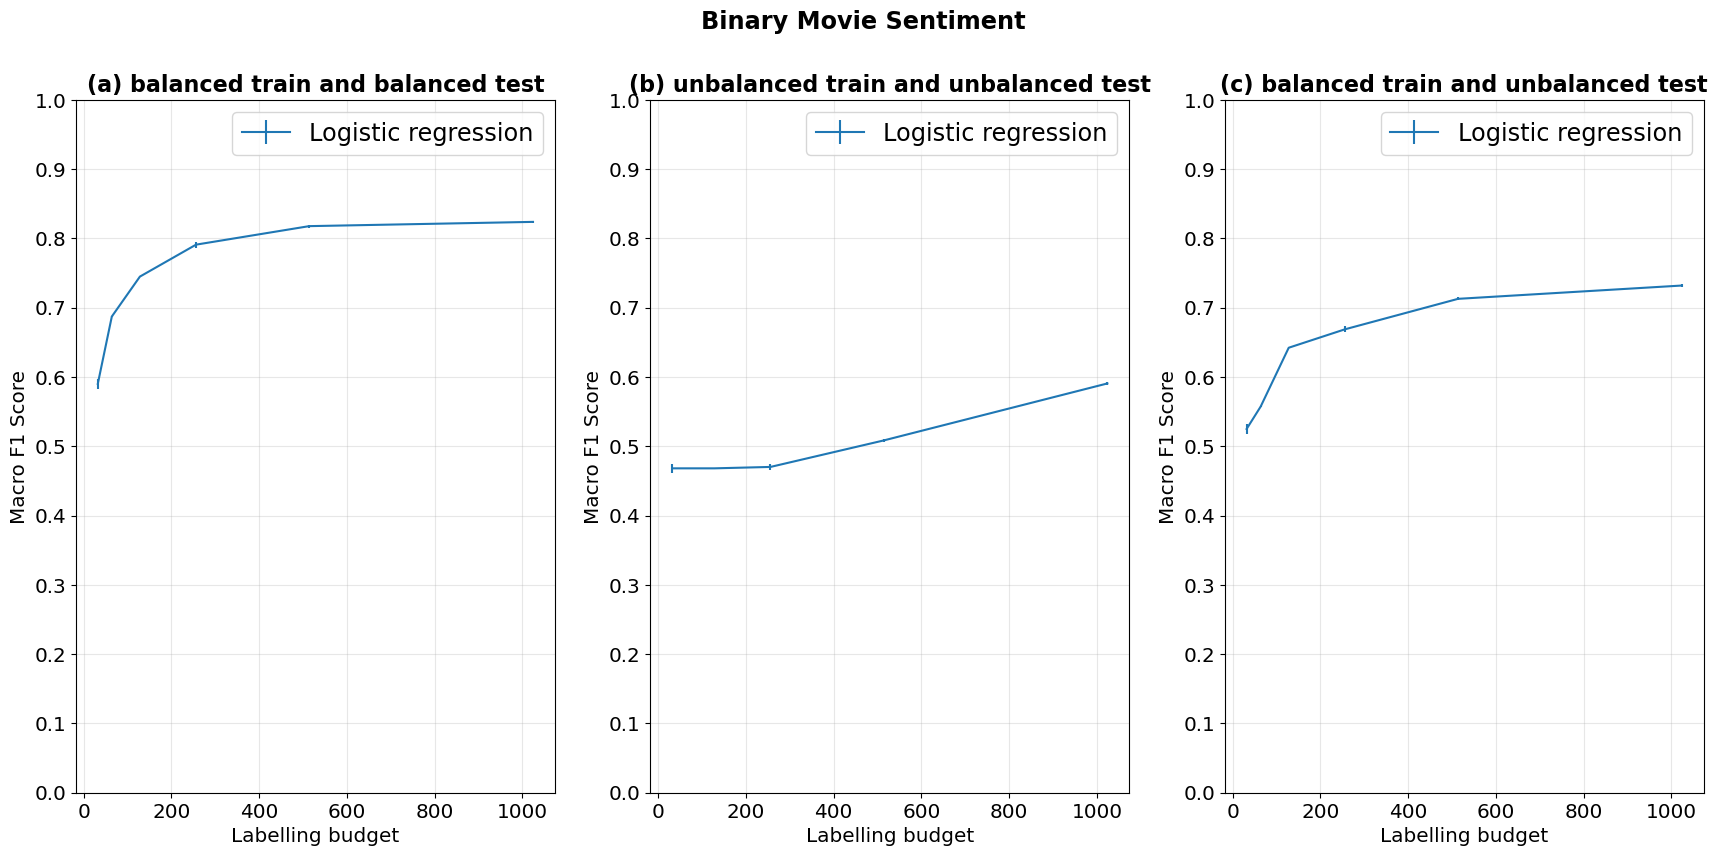

In [14]:
task = "binary_movie_sentiment"
fig, axes = plt.subplots(1, 3, figsize=(21, 9))

fig.suptitle(task.replace("_", " ").title(), fontsize='xx-large', fontweight='semibold')

axes[0].errorbar(x=budgets, y=results_dict_binary_movie_sentiment[task]["balanced"]["balanced"]["f1_macro"].mean(axis=0), 
                yerr=results_dict_binary_movie_sentiment[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), 
                label="Logistic regression")
axes[1].errorbar(x=budgets, y=results_dict_binary_movie_sentiment[task]["unbalanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                yerr=results_dict_binary_movie_sentiment[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), 
                label="Logistic regression")
axes[2].errorbar(x=budgets, y=results_dict_binary_movie_sentiment[task]["balanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_binary_movie_sentiment[task]["balanced"]["balanced"]["f1_macro"].std(axis=0), 
                    label="Logistic regression")

for i in range(3):
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim((0., 1))
    axes[i].set_ylabel("Macro F1 Score", size='x-large')
    axes[i].set_xlabel("Labelling budget", size='x-large')
    axes[i].set_yticks(np.linspace(0, 1, 11))
    axes[i].tick_params(axis='both', which='major', labelsize='x-large')
    axes[i].legend(loc=1, fontsize="xx-large")


axes[0].set_title("(a) balanced train and balanced test", fontweight = 'semibold', fontsize = 16)
axes[1].set_title("(b) unbalanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)
axes[2].set_title("(c) balanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)

plt.savefig("logistic_movie_sentiment.png", format="png", bbox_inches="tight")

# Save results

In [32]:
results_dir = "../results/"
results_filename = "results_logistic_regression.csv"
list_results_to_save = list_results_binary_abuse_to_save + list_results_movie_sentiment_to_save
df_results_to_save = pd.json_normalize(list_results_to_save)
df_results_to_save.to_csv(results_dir+results_filename)